# info
This script generates gene expression distributions as quality control.

In [1]:
import pandas, numpy, seaborn

In [2]:
import scipy, scipy.signal
import sklearn, sklearn.decomposition, sklearn.preprocessing

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':30, 'ytick.labelsize':30, 'axes.labelsize':40, 'figure.figsize':(12, 8)})

# 0. user-defined variables

In [4]:
tpm_file = '/home/adrian/projects/hegoi/results/tpm/DESeq2_TPM_values.tsv'
metadata_file = '/home/adrian/projects/hegoi/metadata/hegoi metadata - metadata.csv'

# 1. read data

In [5]:
df = pandas.read_csv(tpm_file, sep='\t', index_col=0)
print(df.shape)
df.head()

(40320, 26)


,Lam153,Lami154,Lami46,Lami94,LamiP109,LamiP153,LamiP154,LamiP176,LamiPi46,LamiPi94,...,OsciP154,OsciP175,OsciP178,OsciPi46,Stat109,Stat153,Stat154,Stat176,Stat46,Stat94
ENSG00000000003,24.240953,20.242011,22.919919,15.438227,18.098457,29.000777,14.784503,11.903633,26.217884,18.455471,...,38.756393,15.976121,21.649331,28.426877,29.688663,29.207002,28.989493,28.832380,34.600089,27.971771
ENSG00000000005,0.062960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013958,0.000000,0.139231
ENSG00000000419,59.982918,62.984443,120.871295,138.059565,115.707396,84.892000,172.643218,147.901176,145.183145,135.750959,...,98.473591,161.024012,86.023654,115.321222,64.464680,81.686544,84.388415,88.740844,81.992995,97.987628
ENSG00000000457,4.680221,3.684855,1.989328,3.244174,4.417648,2.189278,6.217483,3.998143,4.786793,2.949599,...,3.012943,1.024624,2.255165,2.967113,1.825466,2.371161,3.513856,2.617785,2.546863,2.668982
ENSG00000000460,1.982690,1.344508,1.422365,1.667403,0.570064,2.856698,0.416009,0.000000,1.310974,1.812507,...,5.510741,3.805323,1.489214,0.957885,4.467578,5.425887,7.680067,4.002537,3.650609,4.056977


In [6]:
meta = pandas.read_csv(metadata_file)
print(meta.shape)
meta.head(10)

(33, 6)


,sample label,patient ID,flow type,inorganic phosphate,flow shear stress (dynes),notes
0,Lami46,46.0,laminar,no,20.0,NaN
1,LamiPi46,46.0,laminar,yes,20.0,NaN
2,Osci46,46.0,oscillatory,no,20.0,NaN
3,OsciPi46,46.0,oscillatory,yes,20.0,NaN
4,Stat46,46.0,static,no,0.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,Lami94,94.0,laminar,no,20.0,NaN
7,LamiPi94,94.0,laminar,yes,20.0,NaN
8,Stat94,94.0,static,no,0.0,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


# 2. manipulate data

In [7]:
expressed_genes = df[df.max(axis=1) >= 10]
print(expressed_genes.shape)
expressed_genes.head()

(10867, 26)


,Lam153,Lami154,Lami46,Lami94,LamiP109,LamiP153,LamiP154,LamiP176,LamiPi46,LamiPi94,...,OsciP154,OsciP175,OsciP178,OsciPi46,Stat109,Stat153,Stat154,Stat176,Stat46,Stat94
ENSG00000000003,24.240953,20.242011,22.919919,15.438227,18.098457,29.000777,14.784503,11.903633,26.217884,18.455471,...,38.756393,15.976121,21.649331,28.426877,29.688663,29.207002,28.989493,28.832380,34.600089,27.971771
ENSG00000000419,59.982918,62.984443,120.871295,138.059565,115.707396,84.892000,172.643218,147.901176,145.183145,135.750959,...,98.473591,161.024012,86.023654,115.321222,64.464680,81.686544,84.388415,88.740844,81.992995,97.987628
ENSG00000000938,10.134991,6.846220,0.381629,0.098814,0.000000,7.257495,1.717327,2.182060,0.769253,0.000000,...,0.269178,0.706316,0.138479,0.000000,0.099837,0.800412,0.502107,0.180793,0.178459,0.038659
ENSG00000000971,43.183583,34.392016,17.665019,6.646843,5.668202,34.739437,2.819047,3.599776,21.533249,26.600021,...,16.726394,2.488724,9.021071,20.881451,51.978642,49.667799,28.139268,29.812647,66.887562,58.884221
ENSG00000001036,39.871538,41.119966,34.579811,48.680320,52.898234,43.470339,32.445210,31.183901,33.001406,46.054738,...,41.599477,43.633245,40.476878,40.637731,53.047884,53.087854,62.993872,58.232864,44.205117,59.530942


In [8]:
log2_expressed_genes = numpy.log2(expressed_genes + 1)
log2_expressed_genes.head()

,Lam153,Lami154,Lami46,Lami94,LamiP109,LamiP153,LamiP154,LamiP176,LamiPi46,LamiPi94,...,OsciP154,OsciP175,OsciP178,OsciPi46,Stat109,Stat153,Stat154,Stat176,Stat46,Stat94
ENSG00000000003,4.657694,4.408848,4.580141,4.038983,4.255384,4.906928,3.980437,3.689705,4.766483,4.282104,...,5.313115,4.085435,4.501397,4.879063,4.939634,4.916811,4.906385,4.898807,5.153809,4.856576
ENSG00000000419,5.930333,5.999649,6.929215,7.119559,6.866752,6.424452,7.439982,7.218211,7.191633,7.095407,...,6.636242,7.340064,6.443336,6.861971,6.032645,6.369581,6.415968,6.487693,6.374918,6.629176
ENSG00000000938,3.477029,2.971998,0.466370,0.135947,0.000000,3.045704,1.442188,1.669961,0.823140,0.000000,...,0.343895,0.770885,0.187108,0.000000,0.137289,0.848327,0.586988,0.239756,0.236901,0.054722
ENSG00000000971,5.465439,5.145352,4.222265,2.934864,2.737298,5.159445,1.933213,2.201563,4.493983,4.786597,...,4.147827,1.802699,3.324965,4.451636,5.727339,5.662997,4.864893,4.945451,6.085075,5.904104
ENSG00000001036,5.353025,5.396432,5.152987,5.634603,5.752166,5.474771,5.063728,5.008267,5.087522,5.556268,...,5.412764,5.480047,5.374235,5.379820,5.756166,5.757233,5.999862,5.888326,5.498414,5.919601


# 3. gene expression distributions

150
14.897775039729586


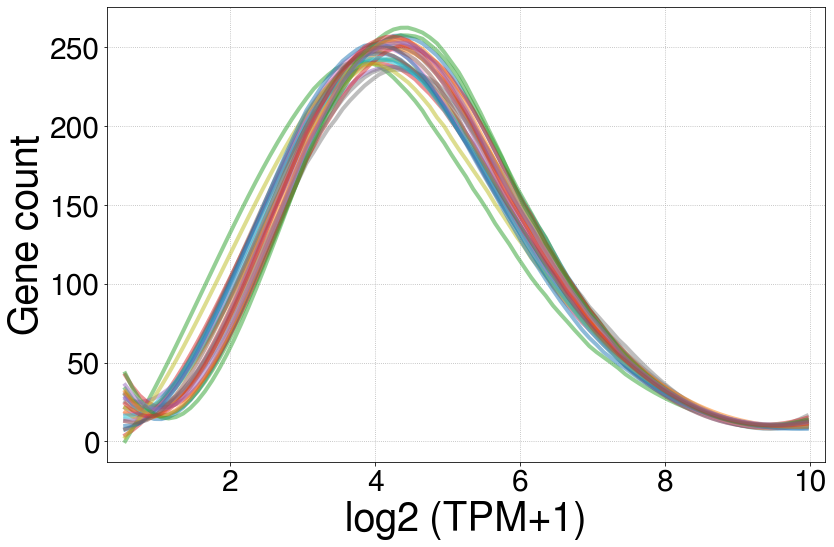

In [9]:
found_max = 15
number_of_bins = found_max*10
print(number_of_bins)

absolute_max = 0
working_samples = log2_expressed_genes.columns.to_list()

most_likely_expressions = []
for sample in working_samples:
    
    log2TPM = log2_expressed_genes.loc[:, sample]
    if max(log2TPM) > absolute_max:
        absolute_max = max(log2TPM)
        
    #print(numpy.min(log2TPM), numpy.max(log2TPM))
        
    hist, bin_edges = numpy.histogram(log2TPM, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    #print(x)
    #print(hist)
   
    plotting_x = x[5:100]
    plotting_hist = hist[5:100]
    #print(plotting_x)
    
    #matplotlib.pyplot.plot(plotting_x, plotting_hist, '.', alpha=1/3)
    
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2)
    
    most_likely_expression = x[numpy.argmax(yhat)]
    most_likely_expressions.append(most_likely_expression)
    
    
matplotlib.pyplot.xlim([numpy.min(plotting_x)-0.25, numpy.max(plotting_x)+0.25])
#matplotlib.pyplot.ylim([0, 1100])

matplotlib.pyplot.xlabel('log2 (TPM+1)')
matplotlib.pyplot.ylabel('Gene count')
matplotlib.pyplot.grid(ls=':')
#matplotlib.pyplot.legend(ncol=10, fontsize=12, bbox_to_anchor=(1.02, 1.25))

matplotlib.pyplot.tight_layout()

print(absolute_max)

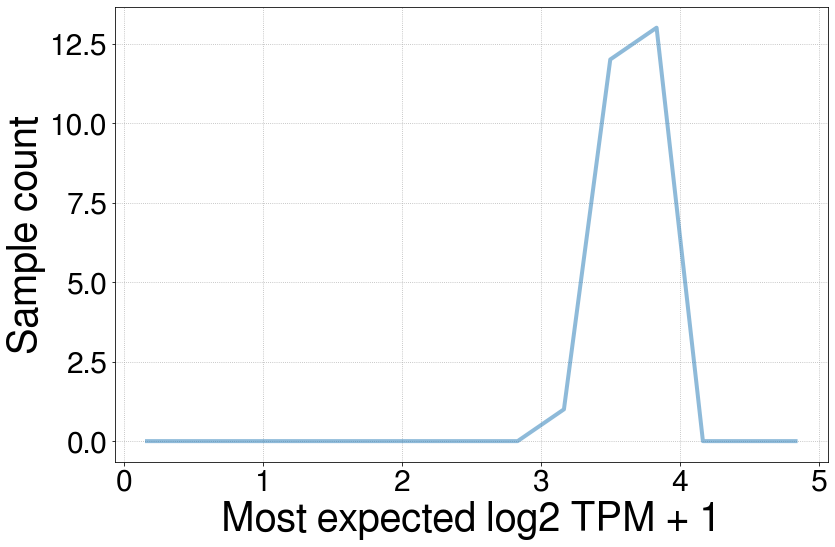

In [10]:
hist, bin_edges = numpy.histogram(most_likely_expressions, bins=15, range=(0, 5))
half_bin = (bin_edges[1] - bin_edges[0])/2
x = bin_edges + half_bin
x = x[:-1]

matplotlib.pyplot.plot(x, hist, '-', lw=4, alpha=1/2)
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.xlabel('Most expected log2 TPM + 1')
matplotlib.pyplot.ylabel('Sample count')
matplotlib.pyplot.tight_layout()

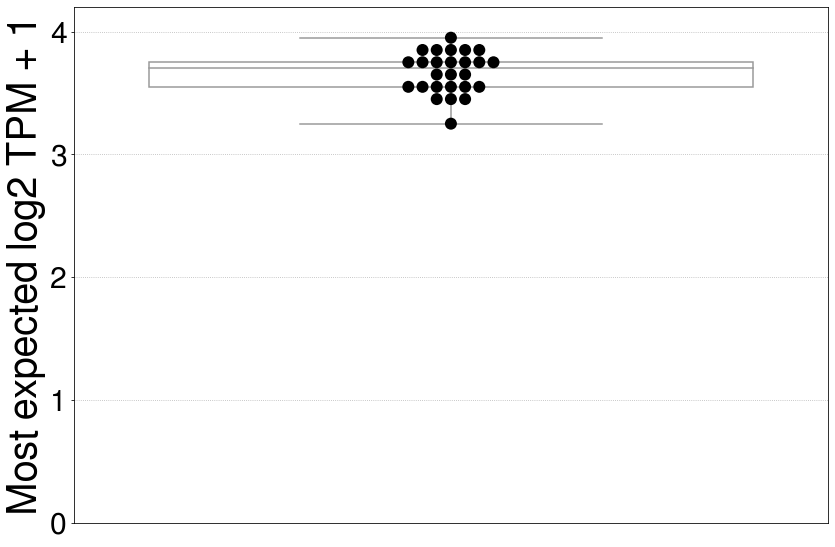

In [11]:
seaborn.boxplot(data=most_likely_expressions, color='white')
seaborn.swarmplot(data=most_likely_expressions, color='black', size=12)
matplotlib.pyplot.ylim([0, 4.2])
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.ylabel('Most expected log2 TPM + 1')
matplotlib.pyplot.xticks([])
matplotlib.pyplot.tight_layout()

# 4. PCA

In [12]:
pca_input = log2_expressed_genes.transpose()

pca = sklearn.decomposition.PCA(n_components=2)
x = sklearn.preprocessing.StandardScaler().fit_transform(pca_input)
principalComponents = pca.fit_transform(x)

print(principalComponents.shape)
print(pca.explained_variance_ratio_)

(26, 2)
[0.23412233 0.13671794]


In [13]:
print(working_samples)

['Lam153', 'Lami154', 'Lami46', 'Lami94', 'LamiP109', 'LamiP153', 'LamiP154', 'LamiP176', 'LamiPi46', 'LamiPi94', 'Osci109', 'Osci153', 'Osci154', 'Osci46', 'OsciP109', 'OsciP153', 'OsciP154', 'OsciP175', 'OsciP178', 'OsciPi46', 'Stat109', 'Stat153', 'Stat154', 'Stat176', 'Stat46', 'Stat94']


In [14]:
meta.head()

,sample label,patient ID,flow type,inorganic phosphate,flow shear stress (dynes),notes
0,Lami46,46.0,laminar,no,20.0,NaN
1,LamiPi46,46.0,laminar,yes,20.0,NaN
2,Osci46,46.0,oscillatory,no,20.0,NaN
3,OsciPi46,46.0,oscillatory,yes,20.0,NaN
4,Stat46,46.0,static,no,0.0,NaN


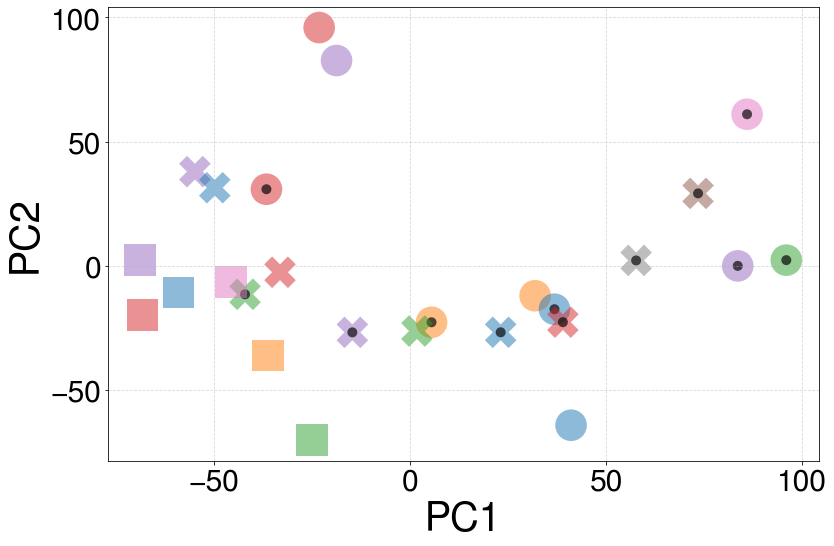

In [15]:
the_color = 'black'
the_marker = 'o'
for i in range(len(working_samples)):
        
    #
    # color about patients
    #
    if meta[meta['sample label'] == working_samples[i]]['patient ID'].values[0] == 46:
        the_color = 'tab:blue'
    elif meta[meta['sample label'] == working_samples[i]]['patient ID'].values[0] == 94:
        the_color = 'tab:orange'
    elif meta[meta['sample label'] == working_samples[i]]['patient ID'].values[0] == 109:
        the_color = 'tab:green'
    elif meta[meta['sample label'] == working_samples[i]]['patient ID'].values[0] == 153:
        the_color = 'tab:red'
    elif meta[meta['sample label'] == working_samples[i]]['patient ID'].values[0] == 154:
        the_color = 'tab:purple'
    elif meta[meta['sample label'] == working_samples[i]]['patient ID'].values[0] == 175:
        the_color = 'tab:brown'
    elif meta[meta['sample label'] == working_samples[i]]['patient ID'].values[0] == 176:
        the_color = 'tab:pink'
    elif meta[meta['sample label'] == working_samples[i]]['patient ID'].values[0] == 178:
        the_color = 'tab:gray'
    else:
        print('another patient found')
        
    #
    # marker based on flow
    #
    if meta[meta['sample label'] == working_samples[i]]['flow type'].values[0] == 'laminar':
        the_marker = 'o'
    if meta[meta['sample label'] == working_samples[i]]['flow type'].values[0] == 'static':
        the_marker = 's'
    if meta[meta['sample label'] == working_samples[i]]['flow type'].values[0] == 'oscillatory':
        the_marker = 'X'
              
    matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c=the_color, s=1000, alpha=0.5, edgecolors='none', marker=the_marker)
    
    #
    # add a dot for with Pi samples
    #
    if meta[meta['sample label'] == working_samples[i]]['inorganic phosphate'].values[0] == 'yes':
        matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c='black', s=100, edgecolors='none', marker='o', alpha=2/3)
    
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.grid(alpha=0.5, ls='--')
matplotlib.pyplot.tight_layout()